This is more or less a test to figure out how to create repositories, etc

In [2]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project`


In [3]:
Pkg.add("Plots")
using Plots # plotting
Pkg.add("LinearAlgebra")
using LinearAlgebra
Pkg.add("CSV")
using CSV
Pkg.add("DataFrames")
using DataFrames

   Resolving package versions...


  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Project.toml`
  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Project.toml`
  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Project.toml`
  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Project.toml`
  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Manifest.toml`


Below starts the actual code. Steps as defined in project update.

## 0. cell matrices ##

In [4]:

#=
map_area=[
    0 .2 1 1 1
    .5 1 1 1 .2
    1 1 .3 0 0]; #fraction of each cell within watershed, FIXME
    =#

#=
map_ag=[
    0 .1 .5 .7 .6
    .2 .7 1 .4 .1
    0 1 .2 0 0]; #ag coefficient of each cell, FIXME
=#

#curve numbers, from soil series -> hydraulic soil types -> weighted 
#avg approximation based on crop type and other land use
#ADJUST, FIXME
#map_CN=90*ones(height_watershed_cells, width_watershed_cells);

#=
map_elevation=[
    20 40 10 10 8
    30 20 15 13 80
    20 10 40 40 40]; #height above outlet, FEET, FIXME
=#


areaDataFrame=CSV.read("map area.csv", DataFrame, header=false, delim=',');
map_area=Matrix(areaDataFrame);


length_cell=304.8; #m, equiv to 1000 ft FIXME
height_watershed_cells=length(map_area[:,1]); #number of cells
width_watershed_cells=length(map_area[1,:]); #number of cells

number_cells_total=height_watershed_cells*width_watershed_cells; #number of cells
area_cell= length_cell^2; #m^2



agDataFrame=CSV.read("map ag.csv", DataFrame, header=false, delim=',');
map_ag=Matrix(agDataFrame);

bareDataFrame=CSV.read("map bare.csv", DataFrame, header=false, delim=',');
map_bare=Matrix(bareDataFrame);

developedDataFrame=CSV.read("map developed.csv", DataFrame, header=false, delim=',');
map_developed=Matrix(developedDataFrame);

treesDataFrame=CSV.read("map trees.csv", DataFrame, header=false, delim=',');
map_trees=Matrix(treesDataFrame);


#FIXME maybe combine ag+bare

#possible soil types are A, B, C, D, A/D, B/D, C/D, denoted as 1, 2, 3, 4, 5, 6, 7 
#0 is not in watershed so hopefully irrelevant
#value indicates majority/plurality soil type in grid square occupied by watershed
soilDataFrame=CSV.read("map soil.csv", DataFrame, header=false, delim=',');
map_soil=Matrix(soilDataFrame);

map_soil[map_soil.>4] .= 4; #all composite types are treated as D

map_soil=Int.(map_soil);

map_CN=zeros(height_watershed_cells, width_watershed_cells);

map_CN_ag=zeros(height_watershed_cells, width_watershed_cells);

map_CN_nonag=zeros(height_watershed_cells, width_watershed_cells);

#down: A, B, C, D
#across: ag, bare, developed, trees (ag as straight row good cond; bare as poor cond w/ residue; 
#developed as small lot town houses; trees as fair cond forest)
values_CN=[67 76 77 36
78 85 85 70
85 90 90 73
89 93 92 79];

for i=1:height_watershed_cells
    for j=1:width_watershed_cells
        if map_soil[i,j] !=0
            #map_CN[i,j]=map_ag[i,j]*values_CN[map_soil[i,j],1]
            total_calc_area=map_ag[i,j]+map_bare[i,j]+map_developed[i,j]+map_trees[i,j];

            map_CN[i,j]=(map_ag[i,j]*values_CN[map_soil[i,j],1]+map_bare[i,j]*values_CN[map_soil[i,j],2]
            +map_developed[i,j]*values_CN[map_soil[i,j],3]+map_trees[i,j]*values_CN[map_soil[i,j],4])/total_calc_area;

            map_CN_ag[i,j]=values_CN[map_soil[i,j],1];  #FIXME if combining bare land adjust this too

            map_CN_nonag[i,j]=(map_bare[i,j]*values_CN[map_soil[i,j],2]
            +map_developed[i,j]*values_CN[map_soil[i,j],3]+map_trees[i,j]*values_CN[map_soil[i,j],4])/(total_calc_area-map_ag[i,j]); 
            #FIXME if combining bare land w/ ag adjust this

        end
    end
end



outlet_cell_coords=[7,1];

map_distance=zeros(height_watershed_cells, width_watershed_cells);
for i in 1:height_watershed_cells
    for j in 1:width_watershed_cells
        map_distance[i,j] = length_cell*sqrt((i-outlet_cell_coords[1])^2+(j-outlet_cell_coords[2])^2);
    end
end

elevationDataFrame=CSV.read("map elevation.csv", DataFrame, header=false, delim=',');
map_elevation=Matrix(elevationDataFrame);

In [109]:
map_ag .+ map_bare .+ map_developed .+ map_trees

26×33 Matrix{Float64}:
 0.0   0.0   0.8   1.0   1.0   1.0   …  1.0   0.95  1.0   1.0   0.9   0.75
 0.0   0.3   0.95  1.0   0.5   0.85     1.0   0.95  1.0   1.0   1.05  0.9
 0.3   0.45  0.9   1.0   1.0   0.25     0.9   1.0   1.0   1.0   1.0   0.85
 0.7   1.0   1.0   1.0   1.0   1.0      0.85  1.0   1.0   1.0   1.0   1.0
 0.75  1.0   1.0   1.0   1.0   1.0      0.75  1.0   1.0   1.0   1.0   1.0
 1.0   1.0   1.0   1.0   1.0   1.0   …  0.95  0.85  1.0   0.95  1.0   1.0
 1.0   1.0   1.0   1.0   1.05  1.0      0.85  1.0   1.0   1.05  1.0   1.0
 1.0   1.0   1.0   1.05  0.9   0.95     0.95  1.0   1.0   1.0   1.0   1.0
 0.95  0.9   1.05  1.0   1.0   1.0      1.0   1.0   1.0   1.0   1.0   1.0
 0.95  0.95  1.0   0.95  1.05  0.95     1.0   1.0   1.0   1.0   1.0   1.0
 ⋮                             ⋮     ⋱                    ⋮           
 0.75  0.55  0.2   0.5   0.5   1.0      1.0   1.1   0.7   0.65  0.75  0.65
 0.0   0.15  0.15  0.65  0.35  1.05     1.0   1.0   1.0   0.95  0.9   0.85
 0.0   0.2   1

## 1. calculating manure and phosphorus ##

In [5]:
depth_applied=.5; #inches, ADJUST FIXME
depth_mixed=.5; #inches, ADJUST FIXME

d_interacting= 0.5*depth_applied/depth_mixed*2.54/100; #m

density_manure=63*16.0185; #kg/m^3

#from Pagliari, 2014
phosphorus_in_manure_amount=10.55 #g/kg
inorg_fract=.695;

In [111]:
maximum(map_CN, dims=2)

26×1 Matrix{Float64}:
  85.14285714285715
  88.70588235294117
  88.33333333333334
  88.8235294117647
  90.72222222222221
  92.0
  92.1904761904762
  92.29999999999998
  92.0
  89.26315789473685
   ⋮
  90.47368421052632
  84.05263157894737
  86.53846153846155
  84.93333333333334
  85.6470588235294
 NaN
 NaN
 NaN
 NaN

## 2. calculating idealized storm ##

In [6]:
#CURRENTLY: 60-min 2-year storm
precip_storm_total=1.57*25.4; #mm, to be tweaked FIXME
duration_storm=60*3; #min, to be tweaked FIXME

intensity_storm=precip_storm_total/duration_storm; #mm/min

## 3. defining calculations for each cell ##

In [47]:
t_runoff_start_matrix=zeros(height_watershed_cells, width_watershed_cells); #minutes
t_c_matrix=zeros(height_watershed_cells, width_watershed_cells); #minutes
vol_matrix=zeros(height_watershed_cells, width_watershed_cells); #m^3
C_matrix=zeros(height_watershed_cells, width_watershed_cells); #g/m^3

number_mins=1000; #length of time arrays

rate_vol_outlet=1.566*49.3/38.6*ones(number_mins); #m^3/sec, array, per minute; calculations are area scaling
C_outlet=11.396*ones(number_mins); #μg/L baseflow concentration, array, per minute; baseflow concentration=11.396

println("real baseflow mass is ", dot(rate_vol_outlet, transpose(C_outlet))/1000/1000*60, " kg")

M_cumulative=0;

for i in 1:height_watershed_cells
    for j in 1:width_watershed_cells
        area_cell_inside=area_cell*map_area[i,j];
        if area_cell_inside>0
            area_ag=area_cell_inside*map_ag[i,j];
            CN=map_CN[i,j];

            CN_ag=map_CN_ag[i,j];
            CN_nonag=map_CN_nonag[i,j];
            distance=map_distance[i,j];
            
            S_ag=25400/CN_ag-254; #mm
            Ia_ag=0.2*S_ag; #mm
    
            S_nonag=25400/CN_nonag-254; #mm
            Ia_nonag=0.2*S_nonag; #mm
    
            depth_Q_ag=0;
            if precip_storm_total>Ia_ag
                depth_Q_ag=(precip_storm_total-Ia_ag)^2/(precip_storm_total-Ia_ag+S_ag); #mm
            end
            vol_Q_ag=depth_Q_ag*area_cell_inside*map_ag[i,j]/1000; #m^3
            vol_Q_ag_liters=vol_Q_ag*1000;
    
    
            depth_Q_nonag=0;
            if precip_storm_total>Ia_nonag
                depth_Q_nonag=(precip_storm_total-Ia_nonag)^2/(precip_storm_total-Ia_nonag+S_nonag)
            end    
            vol_Q_nonag=depth_Q_nonag*(area_cell_inside-area_ag)/area_cell_inside;
             
            
            vol_Q=vol_Q_ag+vol_Q_nonag;
            depth_Q=vol_Q/area_cell_inside;
    
            t_runoff_start=0; #FIXME this couldbe causing issues
            if depth_Q>0
                t_runoff_start=duration_storm*Ia_ag/precip_storm_total; #mins, FIXME BAD RELIES ON IA_AG
            end
            println(t_runoff_start)
            
            rate_vol_Q=vol_Q/(duration_storm-t_runoff_start)/60; #m^3/sec, for individual cell

            #=
            if t_runoff_start<duration_storm #FIXME could be causing issues
                rate_vol_Q=vol_Q/(duration_storm-t_runoff_start)/60; #m^3/sec, for individual cell
            else
                rate_vol_Q=0;
            end
    =#


            #println(rate_vol_Q); #FIXME TEMP


            #------------ MANURE STARTS HERE -------------

            M_interacting_manure=d_interacting*density_manure*area_ag; #kg
            M_interacting_inorg=M_interacting_manure*.733; #g
            
            M_dissolved_inorg=0; #g
            #piecewise function built from plot in Pagliari, 2014
            #=
            if 0<vol_Q_ag_liters/M_interacting_manure<=12.5
                M_dissolved_inorg=((vol_Q_ag_liters/M_interacting_manure-1.7)/10.8*.44+.07)/100*M_interacting_inorg; #g
            elseif 12.5<vol_Q_ag_liters/M_interacting_manure <= 50.8
                M_dissolved_inorg=((vol_Q_ag_liters/M_interacting_manure-12.5)/(50.8-12.5)*.46+.51)/100*M_interacting_inorg; #g
            elseif 50.8<vol_Q_ag_liters/M_interacting_manure
                M_dissolved_inorg=((vol_Q_ag_liters/M_interacting_manure-50.8)/(101.7/50.8)*(0-.06)+.97)/100*M_interacting_inorg; #g
            end
    =#
    
            M_dissolved_inorg=100; #FIXME TEMP
    
            
            #FIXME rate vol is 0 when it shouldn't be
            
    
            if !isnan(M_dissolved_inorg)
                M_cumulative += M_dissolved_inorg; #g, doesn't consider baseflow phosphorus
            end
            
    
            t_runoff_start_matrix[i,j]=t_runoff_start;
            t_c_matrix[i,j]=0.0078*map_distance[i,j]^0.77/(map_elevation[i,j]/map_distance[i,j])^0.385; #minutes
            vol_matrix[i,j]=vol_Q;
    
    
            if !isnan(M_dissolved_inorg) && vol_Q != 0 #avoid NaN values in the concentration matrix when no runoff is occurring, etc
                C_matrix[i,j]=M_dissolved_inorg/vol_Q; #g/m^3=mg/L
            end
    
    
            
            for k=1:length(rate_vol_outlet)
                if t_runoff_start+t_c_matrix[i,j] <=  k <= t_runoff_start+duration_storm+t_c_matrix[i,j]
                    temp_C_outlet=(C_outlet[k]*rate_vol_outlet[k] + C_matrix[i,j]*rate_vol_Q*1000)/(rate_vol_outlet[k]+rate_vol_Q); #μg/L
                    C_outlet[k] = temp_C_outlet
                    rate_vol_outlet[k] += rate_vol_Q;
                end
            end
        end
        
    end
end


println("Mass from runoff is ",M_cumulative/1000, " kg"); #returns cumulative mass in kg
println("Mass from baseflow is ", 1.566 *49.3/38.6*number_mins*60*11.396/1000/1000, " kg") #reasonably sure this is correct
println("(Sanity check): Total mass is ", dot(rate_vol_outlet, transpose(C_outlet))/1000/1000*60, " kg");

real baseflow mass is 1.3675873131606207 kg
28.34037071495024
40.46459348070437
28.34037071495024
28.34037071495024
28.34037071495024
28.34037071495024
28.34037071495024
28.34037071495024
28.34037071495024
28.34037071495024
28.34037071495024
28.34037071495024
40.46459348070437
28.34037071495024
28.34037071495024
40.46459348070437
28.34037071495024
28.34037071495024
28.34037071495024
28.34037071495024
28.34037071495024
40.46459348070437
40.46459348070437
28.34037071495024
28.34037071495024
40.46459348070437
40.46459348070437
40.46459348070437
28.34037071495024
40.46459348070437
28.34037071495024
40.46459348070437
28.34037071495024
40.46459348070437
40.46459348070437
28.34037071495024
40.46459348070437
40.46459348070437
40.46459348070437
40.46459348070437
40.46459348070437
40.46459348070437
40.46459348070437
40.46459348070437
28.34037071495024
40.46459348070437
40.46459348070437
28.34037071495024
28.34037071495024
40.46459348070437
28.34037071495024
40.46459348070437
40.46459348070437
28

28.34037071495024
28.34037071495024
40.46459348070437
28.34037071495024
28.34037071495024
28.34037071495024
28.34037071495024
40.46459348070437
28.34037071495024
28.34037071495024
40.46459348070437
28.34037071495024
28.34037071495024
28.34037071495024
28.34037071495024
40.46459348070437
28.34037071495024
28.34037071495024
28.34037071495024
40.46459348070437
40.46459348070437
28.34037071495024
28.34037071495024
28.34037071495024
28.34037071495024
40.46459348070437
28.34037071495024
40.46459348070437
28.34037071495024
28.34037071495024
28.34037071495024
28.34037071495024
28.34037071495024
40.46459348070437
28.34037071495024
28.34037071495024
28.34037071495024
28.34037071495024
28.34037071495024
28.34037071495024
28.34037071495024
28.34037071495024
40.46459348070437
40.46459348070437
40.46459348070437
40.46459348070437
28.34037071495024
28.34037071495024
40.46459348070437
40.46459348070437
40.46459348070437
28.34037071495024
28.34037071495024
28.34037071495024
28.34037071495024
28.3403707

28.34037071495024
28.34037071495024
40.46459348070437
40.46459348070437
40.46459348070437
40.46459348070437
0
112.93849225211521
40.46459348070437
40.46459348070437
40.46459348070437
40.46459348070437
28.34037071495024
40.46459348070437
28.34037071495024
40.46459348070437
40.46459348070437
40.46459348070437
28.34037071495024
40.46459348070437
28.34037071495024
28.34037071495024
40.46459348070437
40.46459348070437
40.46459348070437
40.46459348070437
112.93849225211521
0
40.46459348070437
40.46459348070437
40.46459348070437
40.46459348070437
40.46459348070437
40.46459348070437
28.34037071495024
40.46459348070437
28.34037071495024
28.34037071495024
28.34037071495024
40.46459348070437
40.46459348070437
40.46459348070437
40.46459348070437
28.34037071495024
40.46459348070437
40.46459348070437
28.34037071495024
28.34037071495024
Mass from runoff is 45.7 kg
Mass from baseflow is 1.3675873131606218 kg
(Sanity check): Total mass is 58.50261799308379 kg


In [44]:
print(duration_storm)

180

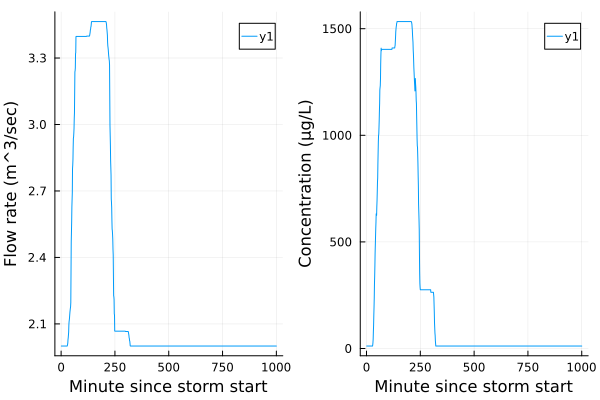

In [48]:
plot_flow=plot(1:number_mins, rate_vol_outlet, xlabel="Minute since storm start", ylabel="Flow rate (m^3/sec)")
plot_C=plot(1:number_mins, C_outlet, xlabel="Minute since storm start", ylabel="Concentration (μg/L)")
plot(plot_flow, plot_C)
